# CNN model

This notebook trains a convolutional layer over the input probability distributions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
np.random.seed(1234)

import sys
sys.path.append("../src")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses
import yaml

from functools import partial
from jrun import jin
from tqdm import tqdm
from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge, Input)
from keras.layers.merge import Concatenate, concatenate
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K

## Setup notebook parameters

In [3]:
EXP_NAME = "collaborative"
data_dir = "../data"
exp_dir = os.path.join(data_dir, "processed", EXP_NAME)

with open("../config.yaml") as fp:
    CONFIG = yaml.load(fp)
    
TEST_SPLIT_THRESH = CONFIG["TEST_SPLIT_THRESH"][EXP_NAME]

COMPONENTS = [udata.Component(exp_dir, name) for name in u.available_models(exp_dir)]
ACTUAL_DL = udata.ActualDataLoader(data_dir)

REGIONS = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]
TARGETS = [udata.Target(t) for t in [1, 2, 3, 4, "peak", "peak_wk", "onset_wk"]]

### Data split

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [4]:
target = TARGETS[0]

y_train, Xs_train, yi_train = target.get_training_data(
    ACTUAL_DL, COMPONENTS, None, TEST_SPLIT_THRESH
)

### Creating input matrices for model

In [5]:
X_train = udists.get_2d_features(Xs_train)
y_one_hot_train = udists.actual_to_one_hot(y_train, bins=target.bins)

## Model

In [24]:
def conv1D_distribution(n_components, n_bins):
    """
    One dimensional conv model over input distribution to give an output
    distribution

    Parameters
    ----------
    n_components : int
        Number of component distributions
    n_bins : int
        Number of bins in the prediction distribution
    """

    dist_input = Input(shape=(n_bins, n_components))
    
    if n_bins < 50:
        dist_x = Convolution1D(32, 5, padding="same")(dist_input)
        dist_x = Convolution1D(10, 3, padding="same")(dist_x)
    else:
        dist_x = Convolution1D(10, 3, padding="same")(dist_input)
        dist_x = Convolution1D(10, 3, padding="same")(dist_x)

    dist_x = Flatten()(dist_x)
    dist_x = Dense(10, activation="tanh")(dist_x)
    dist_x = Dense(n_bins, activation="softmax")(dist_x)
    
    model = Model(inputs=dist_input, outputs=dist_x)

    return model

### Training

In [25]:
# model generator
def gen_model():
    return conv1D_distribution(X_train.shape[-1], X_train.shape[1])

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100,
    verbose=0
):
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=2, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=val_data,
                        shuffle=False)
    return history

100%|██████████| 5/5 [00:37<00:00,  8.41s/it]


,epochs,train_loss,val_loss
it-1,9.0,1.802640,3.245632
it-2,4.0,2.394963,3.886374
it-3,24.0,1.434624,2.572336
it-4,58.0,1.018666,2.095170
it-5,46.0,1.084506,2.348079
mean (median for epochs),24.0,1.547080,2.829518


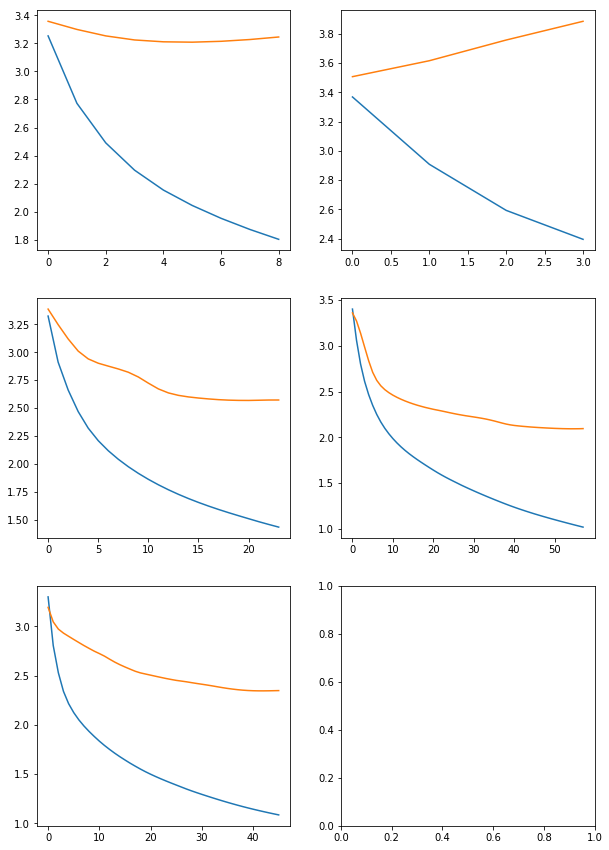

In [26]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X_train, y_one_hot_train, yi_train
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

1.4319450900544952

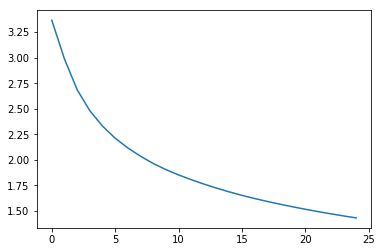

In [19]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(
    model,
    [X_train, y_one_hot_train],
    None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [20]:
eval_df = {
    "region": [],
    "score": []
}

for region in tqdm(REGIONS):
    y_test, Xs_test, yi_test = target.get_testing_data(
        ACTUAL_DL, COMPONENTS, region, TEST_SPLIT_THRESH
    )
    
    X_test = udists.get_2d_features(Xs_test)
    output = model.predict(X_test)
    y_one_hot = udists.actual_to_one_hot(y_test, bins=target.bins)
    
    eval_df["region"].append(region if region is not None else "all")
    eval_df["score"].append(losses.mean_cat_cross(y_one_hot, output))

eval_df = pd.DataFrame(eval_df)

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}/{target.name}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs    
}, f"{output_dir}/cnn_summary.txt")
eval_df.to_csv(f"{output_dir}/cnn.csv", index=False)
eval_df

100%|██████████| 12/12 [00:51<00:00,  4.24s/it]


,region,score
0,nat,1.291825859202552
1,hhs1,1.6614181626703322
2,hhs2,2.582823076506251
3,hhs3,0.873267424168046
4,hhs4,2.6197902904343358
5,hhs5,2.834301895087527
6,hhs6,1.049087095813653
7,hhs7,2.977002355855765
8,hhs8,1.4215688533389692
9,hhs9,1.2455938267953617
